In [3]:
import os
import cv2
import numpy as np
from tqdm import tqdm
from PIL import Image
from glob import glob
from easydict import EasyDict
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.cuda import amp
import torch.nn.functional as F
from torchvision import transforms
from torchmetrics import MeanMetric
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import save_image,make_grid

from model import SimpleUnet

import warnings
warnings.filterwarnings('ignore')

In [4]:
config = EasyDict({
    'T': 1000,
    'img_shape': (3, 32, 32),
    'batch_size': 32,
    'B1': 0.0001,
    'BT': 0.02,
    'LR': 0.001,
    'epochs': 100,
    'device': 'cuda' if torch.cuda.is_available() else 'cpu',
    'data_root': '/kaggle/input/celeba-dataset/img_align_celeba/img_align_celeba/',
})

In [5]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.CenterCrop((140,140)),
    transforms.Resize((32,32)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.Lambda(lambda x: (x * 2) - 1) # Scale between [-1, 1] 

])

In [6]:
class CelebADataset(Dataset):
    def __init__(self, path, transform):
        super().__init__()
        self.image_paths = path
        self.transform = transform
    
    def __getitem__(self, index):
        image_path = self.image_paths[index]
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = self.transform(image)
            
        return image
            
    def __len__(self):
        return len(self.image_paths)

In [7]:
# Dataset
total_path = glob(os.path.join(config.data_root, '*'))
X_train, X_test = train_test_split(total_path, test_size=0.2, random_state=42)

train_dataset = CelebADataset(X_train, transform)
test_dataset = CelebADataset(X_test, transform)
train_loader = DataLoader(train_dataset, batch_size=config.batch_size, drop_last=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=config.batch_size, drop_last=True, num_workers=4)


Shape of Batch Data: torch.Size([32, 3, 32, 32])
tensor(-0.9787) tensor(1.) tensor(0.0107) tensor(1.)


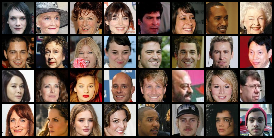

In [8]:
for X in train_loader:
    inverse_X = transforms.Lambda(lambda x : (x+1)/2.0)(X) # scale back to 0~1
    save_image(inverse_X,"./aug_check.png")
    print(f"Shape of Batch Data: {inverse_X.shape}")
    break

print(X[0].min(), X[0].max(), inverse_X[0].min(), inverse_X[0].max())
Image.open("./aug_check.png")

## Forward(Diffusion) Process

</br>

$q(x_t|x_{t-1}) = \sqrt{1-\beta_t}x_{t-1}+\sqrt{\beta_t}\epsilon_{t-1} \ _{\text{where } \epsilon_{t-1} \sim N(0,I)}$

Forward process는 입력 이미지 $x_0$에 점진적으로 gaussian noise를 주입하는 과정이다. 각 time step $t$에서의 forward process는 $q(x_t|x_{t-1})$, $t=0$에서 $t=T$까지의 전체 과정은 $q(x_{1:T}|x_0)$로 표현된다. 이때 주입되는 gaussian noise의 크기인 분산은 $\beta_t$로 표기된다. 또한 각 time step에서의 forward process는 reparameterization trick을 적용하여 아래와 같이 일반화하여 표현할 수 있다. 논문에서는 $T=1000$으로 설정하였고, 총 1000번의 forward process를 거친 $x_T$는 (거의) 완전한 gaussian 분포를 따르게 된다. 

</br>

Forward process에서 주목할만한 특성은 $x_t$를 얻기 위해 $x_0$에서 $t$번의 노이즈 주입 과정을 거치지 않고도 $x_0$에서 한번에 $x_t$를 계산할 수 있다는 것이다.  $\alpha_t = 1-\beta_t, \ \bar{\alpha}_t = \prod_{i=1}^t\alpha_i$라고 했을 때, $x_t$를 $x_{t-1}$로 나타낼 수 있고, 이를 다시 $x_{t-2}$로 나타낼 수 있다. 반복한다면 결국 $x_0$으로 $x_t$를 표현할 수 있게 되는 것이다. 식을 정리하다보면 forward process $q$는 다시 아래와 같이 한번에 계산될 수 있게끔 표현된다.

$ q(x_t|x_0) = N(x_t; \sqrt{\bar{\alpha}}_tx_0, (1-\bar{\alpha}_t)I) \\[11pt]  \longrightarrow x_t = \sqrt{\bar{\alpha_t}}\cdot x_0 + \sqrt{(1-\bar{\alpha}_t)} \cdot \epsilon, \ _{\text{ where } \epsilon \sim N(0,I), \ \ \bar \alpha_t = \prod_{i=1}^t \alpha_i}$

</br>

학습은 $t \sim \text{Uniform}(\{1,...,T\})$ 에 해당하는 노이즈낀 이미지들을 batch 단위로 넣어줌으로써 이루어진다. 같은 이미지에 대해서 1~T까지 학습하는 것보다 효율적이라고 한다.

In [9]:
class PredefinedDiffusion:
    def __init__(self, config):
        self.num_timesteps = config.T
        self.beta_1 = config.B1 # 0.0001
        self.beta_T = config.BT # 0.02
        self.img_shape = config.img_shape
        self.device = config.device
        self.initialize()

    def initialize(self):
        self.betas = self.get_betas()
        self.alphas = 1-self.betas
        self.alphas_cum = torch.cumprod(self.alphas, dim=0)
        self.sqrt_alphas_cum = torch.sqrt(self.alphas_cum)
        self.one_over_sqrt_alphas = 1.0 / torch.sqrt(self.alphas)
        self.sqrt_one_minus_alphas_cum = torch.sqrt(1. - self.alphas_cum)
        
        pass
    
    def get_betas(self):
        # 0.0001 ~ 0.02까지 1000 스텝으로 linear schedule
        betas = torch.linspace(self.beta_1, 
                               self.beta_T, 
                               self.num_timesteps, 
                               dtype=torch.float32, 
                               device=config.device)
        return betas

- `self.betas` = $\beta_t, t=\{1,...,T\}$
- `self.alphas` = $1-\beta_t$
- `self.alphas_cum` = $\bar \alpha_t$
- `self.sqrt_alphas_cum` = $\sqrt{\bar \alpha_t}$
- `self.one_over_sqrt_alphas` = $\frac{1}{\sqrt{\alpha_t}}$
- `self.sqrt_one_minus_alphas_cum` = $\sqrt{1-\bar \alpha_t}$

In [10]:
def get(vals, timestep):
#     ele = vals.gather(-1, timestep) # Timestep t에서의 predefined 값들을 가져옴
    element = vals[timestep] # Timestep t에서의 predefined 값들을 가져옴
    return element.reshape(-1, 1, 1, 1) 

def forward_process(pd: PredefinedDiffusion, x0, timesteps):
    epsilon = torch.randn_like(x0) # x0 ~ N(0,I)
    mu = get(pd.sqrt_alphas_cum, timesteps) * x0 # Image scaled
    sigma = get(pd.sqrt_one_minus_alphas_cum, timesteps) # Noise scaled
    x_t = mu + sigma * epsilon # Reparameterization trick
    return x_t, epsilon

`forward_process 함수`

$ q(x_t|x_0) = N(x_t; \sqrt{\bar{\alpha}}_tx_0, (1-\bar{\alpha}_t)I) \\[11pt]   \longrightarrow x_t = \sqrt{\bar{\alpha_t}}\cdot x_0 + \sqrt{(1-\bar{\alpha}_t)} \cdot \epsilon, \ _{\text{ where } \epsilon \sim N(0,I), \ \ \bar \alpha_t = \prod_{i=1}^t \alpha_i} $

- `epsilon` = $\epsilon$
- `mu` = $\sqrt{\bar{\alpha_t}}\cdot x_0$
- `sigma` = $\sqrt{(1-\bar{\alpha}_t)}$
- `x_t` = $x_t$

In [11]:
# Visualize Forward(Diffusion) Process
pd = PredefinedDiffusion(config)

sample_dataset = CelebADataset(X_train, transform)
sample_loader = DataLoader(sample_dataset, batch_size=6, drop_last=True, num_workers=4)

loader = iter(sample_loader)
Xs = next(loader).to(config.device) # 6개의 sample만 확인

In [12]:
noisy_images = []
specific_timesteps = [0, 10, 50, 100, 150, 200, 250, 300, 400, 600, 800, 999]
for timestep in specific_timesteps:
    timestep = torch.as_tensor(timestep, dtype=torch.long)
    x_ts, _ = forward_process(pd, Xs, timestep)
    inverse_x_ts = transforms.Lambda(lambda x : (x+1)/2.0)(x_ts) # scale back to 0~1
    inverse_x_ts = make_grid(inverse_x_ts, nrow=1, padding=1)
    noisy_images.append(inverse_x_ts)


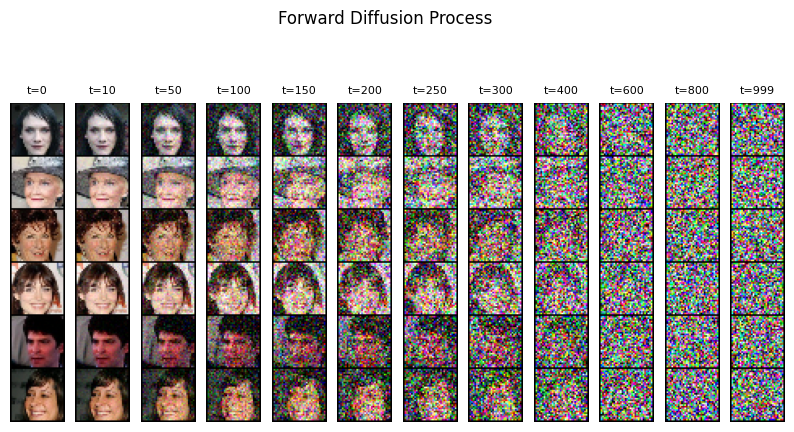

In [13]:
_, ax = plt.subplots(1, len(noisy_images), figsize=(10, 5), facecolor="white")

for i, (timestep, noisy_sample) in enumerate(zip(specific_timesteps, noisy_images)):
    ax[i].imshow(noisy_sample.detach().cpu().squeeze(0).permute(1, 2, 0))
    ax[i].set_title(f"t={timestep}", fontsize=8)
    ax[i].axis("off")
    ax[i].grid(False)

plt.suptitle("Forward Diffusion Process", y=1)
plt.axis("off")
plt.show()

---
## Reverse Process

Reverse Process는 gaussian noise인 $x_T$에서 조금씩 noise를 제거하여 깨끗한 이미지 $x_0$를 만드는 과정이다. 이때, 앞서 말했던 것처럼 forward process인 $q(x_t|x_{t-1})$를 뒤집은 $q(x_{t-1}|x)$를 직접 계산할 수 없으니, 이를 근사하는 $p_{\theta}(x_{t-1}|x_t)$를 학습한다. Variance인 $\beta_t$가 매우 작을 때 $q(x_{t}|x_{t-1})$와 $q(x_{t-1}|x_t)$ 모두 gaussian 분포를 따른다는 증명에 따라, $p_{\theta}(x_{t-1}|x_t)$ 역시 gaussian 분포로 표현될 수 있다고 가정한다. 따라서 $p_{\theta}(x_{t-1}|x_t)$가 예측해야하는 것은, 조건부 gaussian 분포의 모수인 mean과 variance이 되는 것이다. 

이때, DDPM 저자들은 $\mu_{\theta}, \sum_{\theta}$가 아닌 $\epsilon_{\theta}$를 예측하는 것으로 문제를 단순화하였다.

</br>

<img src="./figure/sampling.png" width="400">

In [59]:
@torch.no_grad()
def reverse_process(model, pd, config, grid_size=8, vis=True):
    num_images = grid_size**2
    imgs = []

    # Algorithm 2 Sampling
    # Line 1: x_T ~ N(0,I)
    x = torch.randn((num_images, *config.img_shape), device=config.device) # torch.Size([num_images, 3, 32, 32])

    model.eval()

    # Line 2: for t=T,...,1 do
    for t in tqdm(iterable=reversed(range(1, config.T)), total=config.T-1):
        
        # Line 3: z~N(0,I) if t>1, else z=0
        z = torch.randn_like(x) if t>1 else torch.zeros_like(x)
        t_inputs = torch.ones(num_images,dtype=torch.long, device=config.device) * t # e.g. t시점= [t,t,t,t,t]. 모델의 time step 입력

        pred_noise = model(x, t_inputs)

        # Line 4: x_{t-1} 계산
        betas = get(pd.betas, t_inputs) # t 시점에서의 beta
        one_over_sqrt_alphas = get(pd.one_over_sqrt_alphas, t_inputs) # t 시점에서의 1/sqrt(alpha)
        sqrt_one_minus_alphas_cum = get(pd.sqrt_one_minus_alphas_cum, t_inputs) # t 시점에서의 sqrt(1-bar(alphas))

        x = one_over_sqrt_alphas * (x - betas/sqrt_one_minus_alphas_cum * pred_noise) + torch.sqrt(betas)*z

        # For visualization
        if vis and t%20==0:
            x_inverse = transforms.Lambda(lambda x : (x.clamp(-1, 1) + 1) / 2.0)(x) * 255. # scale back to 0~255
            image_grid = make_grid(x_inverse, nrow=grid_size)
            image_grid = Image.fromarray(image_grid.permute(1, 2, 0).detach().to('cpu', torch.uint8).numpy())
            imgs.append(image_grid)
    
    if vis:
        imgs[0].save("./video/movie.gif", save_all=True, append_images=imgs[1:], duration=1, loop=0)
#         return None
    
#     else: # Display and save the image at the final timestep of the reverse process. 
        x_inverse = transforms.Lambda(lambda x : (x.clamp(-1, 1) + 1) / 2.0)(x) * 255. # scale back to 0~255
        image_grid = make_grid(x_inverse, nrow=grid_size)
        image_grid = Image.fromarray(image_grid.permute(1, 2, 0).detach().to('cpu', torch.uint8).numpy())
        image_grid.save('result.png')
        return None



---

## Training

In [15]:
model = SimpleUnet().to(config.device)

optimizer = torch.optim.Adam(model.parameters(), lr=config.LR)
criterion = nn.MSELoss()

scaler = amp.GradScaler() # For mixed-precision training.
pd = PredefinedDiffusion(config)

<img src="./figure/training.png" width="400">

In [ ]:
for epoch in range(config.epochs):
    torch.cuda.empty_cache()
    loss_record = MeanMetric()
    model.train()
    
    with tqdm(total=len(train_loader), dynamic_ncols=True) as tq:
        tq.set_description(f"Train :: Epoch: {epoch}/{config.epochs}")
    
        for X in train_loader: # Line 2: x_0 ~ q(x_0)
            tq.update(1)
            X = X.to(config.device)
            # Line 3: t ~ Uniform({1,...,T})
            sampled_t = torch.randint(low=1, high=config.T, size=(X.shape[0],), device=config.device)
            
            # Line 4: epsilon(true noise) ~ N(0,I)
            x_t, true_noise = forward_process(pd, X, sampled_t)
            
            with amp.autocast():
                pred_noise = model(x_t, sampled_t)
                
                # Line 5: MSE loss. ||gt_noist - pred_noise||^2
                loss = criterion(true_noise, pred_noise)
                
            optimizer.zero_grad()
            scaler.scale(loss).backward()
            
            scaler.step(optimizer)
            scaler.update()
            
            loss_value = loss.detach().item()
            loss_record.update(loss_value)
            tq.set_postfix_str(s=f"Loss: {loss_value:.4f}")
            
            
        mean_loss = loss_record.compute().item()
        tq.set_postfix_str(s=f"Epoch Loss: {mean_loss:.4f}")

    if epoch % 10 == 0:
        if not os.path.exists('./video'):
            os.makedirs('./video')
        save_path = os.path.join('./video', f"{epoch}.gif")

        reverse_process(model, pd, config, grid_size=8, vis=True) ###

        checkpoint_dict = {
            "opt": optimizer.state_dict(),
            "scaler": scaler.state_dict(),
            "model": model.state_dict()
        }
        torch.save(checkpoint_dict, f"ckpt_{epoch}.pt")
        del checkpoint_dict

Train :: Epoch: 3/100:  38%|███▊      | 1899/5064 [02:57<04:51, 10.87it/s, Loss: 0.0436]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Train :: Epoch: 4/100:  17%|█▋        | 862/5064 [01:21<06:31, 10.73it/s, Loss: 0.0222]

In [69]:
# Load Model
ckpt_path = '/kaggle/input/ddpm-models/ckpt_20.pt'
model.load_state_dict(torch.load(ckpt_path)['model'])
model.eval()
if not os.path.exists('./video'):
    os.makedirs('./video')
    
reverse_process(model, pd, config, grid_size=8,vis=True)

100%|██████████| 999/999 [00:39<00:00, 25.27it/s]
